<a href="https://colab.research.google.com/github/lnsayer/udemy_ml_course/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Workflow

Let's explore an example Pytorch end-to-end workflow.

Resources:
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/docs/01_pytorch_workflow.ipynb
* Book version of notebook https://www.learnpytorch.io/01_pytorch_workflow/
* Ask a question https://github.com/mrdbourke/pytorch-deep-learning/discussions

In [161]:
what_were_covering = {1: "data (prepare and load)",
                              2: "build model",
                              3: "fitting the model to data (training)",
                              4: "making predictions and evaluting a model (inference)",
                              5: "saving and loading a model",
                              6: "putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluting a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [162]:
import torch
from torch import nn # nn contains all of Pytorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

# Check PyTorch version
torch.__version__

'2.2.1+cu121'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel speadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula

We'll use a linear regression formula to make a straight line with known **parameters**

In [163]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [164]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in general)

Let's create a training and test set with our data

In [165]:
# Create a train/test split
train_split = int(0.8 *len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualise our data?

This is where the data explorer's motto comes in!

"Visualise, visualise, visualise!"

In [166]:
def plot_predictions(train_data=X_train,
                     train_labels = y_train,
                     test_data=X_test,
                     test_labels = y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))


  #Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")


  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size":14})

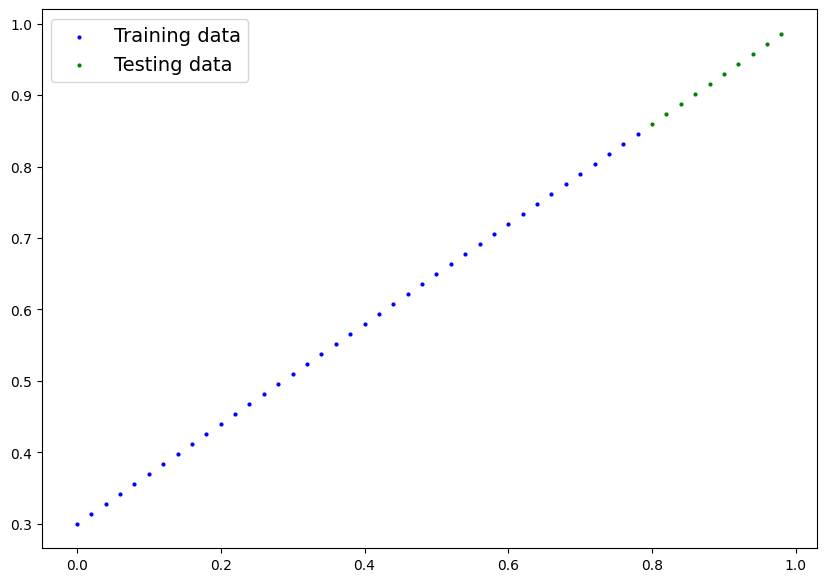

In [167]:
plot_predictions();

## 2. Building model

Our first Pytorch model

This is very exciting... let's do it.

Because we're going to be building classes throughout the course, I'd recommend: https://realpython.com/python-classes/

What our model does:
* Start with random values (weight and bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient Descent
2. Backpropagation

In [168]:
from torch import nn

# Create a linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in Pytorch inherits from nn.module
    def __init__(self):
      super().__init__()
      # Initialise the model parameters
      self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                              requires_grad=True, # <- can this parameter be updated by gradient descent?
                                              dtype = torch.float)) # Pytorch loves the datatype torch.float32

      self.bias = nn.Parameter(torch.randn(1, # <- start with a random bias and adjust it to the ideal bias
                                           requires_grad=True, # can this parameter be updated via gradient descent?
                                           dtype= torch.float)) # Pytorch loves the datatype torch.float32

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
      return self.weights * x+ self.bias # This is the linear regression formula




### PyTorch model building essentials

* torch.nn - contains all of the building blocks for computational graphs( a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a Pytorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimisers in Pytorch live, they will help with gradient descent
* def forward() - All nn.module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

See more here:  https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our Pytorch model

Now we've created a model, let's see what's inside...

So we can check out our model parameters or what's inside our model using `.parameters()`

In [169]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [170]:
 # List parameters names
 model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, it's going to run it through the forward method.

In [171]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [172]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# You can also do something similar with torch.no_grad(), however, inference mode is preferred
# with torch.no_grad():
#   y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [173]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

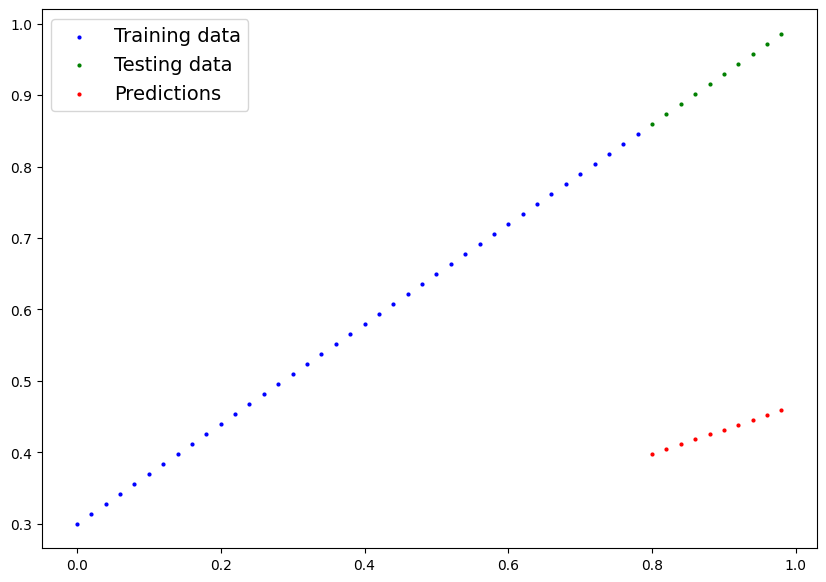

In [174]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some unknown parameters (these may be random) to some known parameters

Or in other words, from a poor representation to a better representation of the data.

One way to measure how our poor your models predictions' are, use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss Function:** A function to measure how wrong your model's predictions are to the outputs, lower is better.
* **Optimiser:** Takes into account the loss of a model and adjusts the model's parameters (e.g weight and bias) to improve the loss function.

And specifically for Pytorch, we need:
* A training loop
* A testing loop

In [175]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [176]:
# Check out our model's parameters (a parameter is a value that the model set itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [177]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Set up an optimiser (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01) # lr= learning rate, possibly the most important hyperparameter you can set


### Building a training loop (and a testing loop) in PyTorch

 A couple of things we need in a training loop:
 0. Loop through the data
 1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
 2. Calculate the loss (compare forward pass predictions to ground truth labels)
 3. Optimiser zero grad
 4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with repsect to the loss (**backpropagation**)
 5. Optimiser step - use the optimiser to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [178]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [179]:
# An epoch is one loop through the data...(this is a hyperparameter because we've set it ourselves)
epochs = 200

epoch_count = []
train_loss_values = []
test_loss_values = []

#Training
# 0. Loop through the data and do...
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients

  #1. Forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)

  #2. Calculate the loss (depends on the loss function in use)
  loss = loss_fn(y_pred, y_train)
  # print(f"loss: {loss}")

  #3. Zero the gradients of the optimizer (they accumulate by default)
  optimizer.zero_grad()

  #4. Perform backpropagation on the loss w.r.t the parameters of the model
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() # by defualt how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop


  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing
  with torch.inference_mode(): # turns off gradient tracking and a couple more things behind the scene
    # 1. Do the forward pass
    test_pred = model_0(X_test)


    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch %10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model_0 state_dict
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

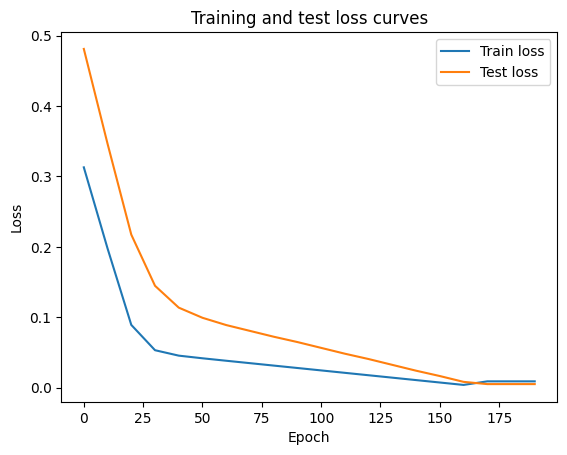

In [180]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

In [181]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [182]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

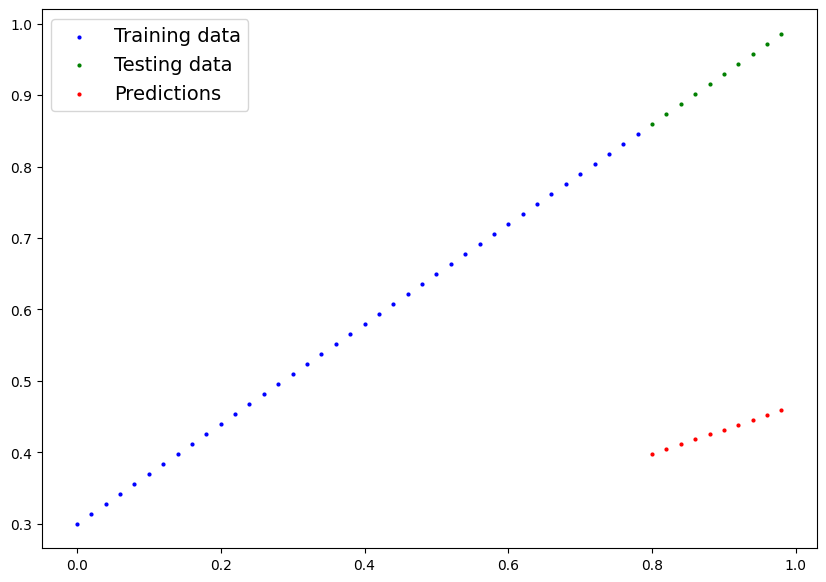

In [183]:
plot_predictions(predictions=y_preds);

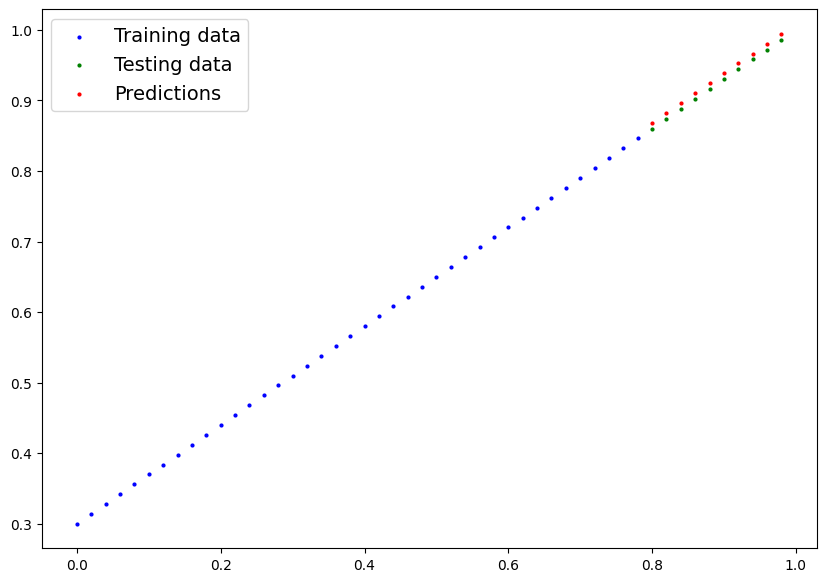

In [184]:
plot_predictions(predictions=y_preds_new);

## Saving a model in PyTorch

There are three main methods for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict` - this allows you to load a model's saved state dictionary

PyTorhc save and load code tutorial + extra-curriculum https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

In [185]:
# Saving our PyTorhc model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state_dict()
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj= model_0.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_0.pth


In [186]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Apr  5 16:49 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()`, we'll create a new instance of our model class and load the saved `state_dict()` into that.


In [190]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict() of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [191]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [192]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds


tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [195]:
# Make some models preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)


In [196]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place.


In [200]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib

# Check PyTorch version
torch.__version__


'2.2.1+cu121'

In [201]:
Create device agnostic code.

This means if we've got access to a GPU, our code will use it (potentiall for faster computing).

If no GPU is availab


SyntaxError: invalid syntax (<ipython-input-201-b19ff18d4efe>, line 1)

In [197]:
# 6.1 Data